# Capstone3 - 3 Pre-processing and Training Data Development & Modeling

# 3.1 Imports 

In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

C:\Users\JIYOON JUNG\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 3.2 Load Data

In [2]:
df = pd.read_csv(r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 32 Advanced Data Visualization\Capstone 3\df')

In [3]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,...,customer_state,geolocation_lat,geolocation_lng,product_category_name_english,order_size,product_order_size,Year,Month,product_sales_amt,order_sales_amt
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,...,SP,-23.576170,-46.587276,housewares,1,1,2017,10,29.99,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,...,BA,-12.126651,-45.008162,perfumery,1,1,2018,7,118.70,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-09-04,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,...,GO,-16.744472,-48.514624,auto,1,1,2018,8,159.90,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,...,RN,-5.774611,-35.273916,pet_shop,1,1,2017,11,45.00,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,...,SP,-23.675316,-46.515116,stationery,1,1,2018,2,19.90,19.90


In [4]:
df.shape

(100196, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100196 entries, 0 to 100195
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       100196 non-null  object 
 1   customer_id                    100196 non-null  object 
 2   order_status                   100196 non-null  object 
 3   order_purchase_timestamp       100196 non-null  object 
 4   order_estimated_delivery_date  100196 non-null  object 
 5   product_id                     100196 non-null  object 
 6   seller_id                      100196 non-null  object 
 7   shipping_limit_date            100196 non-null  object 
 8   price                          100196 non-null  float64
 9   freight_value                  100196 non-null  float64
 10  customer_unique_id             100196 non-null  object 
 11  customer_zip_code_prefix       100196 non-null  int64  
 12  customer_city                 

#### Change the datatype

In [6]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

#### Data Preparation

In [7]:
print('Min:{}; Max:{}'.format(min(df.order_purchase_timestamp),max(df.order_purchase_timestamp)))

Min:2016-09-15 12:16:38; Max:2018-08-29 15:00:37


In [8]:
df = df[(df['order_purchase_timestamp'] > pd.to_datetime('2017-08-01')) & 
        (df['order_purchase_timestamp'] < pd.to_datetime('2018-07-31'))]

In [9]:
print('Min:{}; Max:{}'.format(min(df.order_purchase_timestamp),max(df.order_purchase_timestamp)))

Min:2017-08-01 00:02:01; Max:2018-07-30 23:54:48


# 3.3 Customer Segmentation

1. Sort customers based on that metric
    - Recency (R): Days since the customer's last purchase
    - Frequency (F): Number of products bought by the customer
    - Monetary Value (M): Total spent on purchases
    

2. Break customers into a pre-defined number of groups of equal size
    - K-Means clustering


3. Assign a label to each group

In [10]:
max_date = max(df['order_purchase_timestamp']) + datetime.timedelta(days=1)

In [14]:
rfm_data = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'product_sales_amt':'sum'
}).reset_index()
rfm_data.columns =['customer_id','recency','frequency','monetary']

In [15]:
rfm_data.head()

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,82,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,292,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,259,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,117,1,154.00


### 3.3.1 Recency

count    69749.000000
mean       169.490946
std         98.539392
min          1.000000
25%         88.000000
50%        165.000000
75%        248.000000
max        364.000000
Name: recency, dtype: float64


<AxesSubplot:xlabel='recency', ylabel='Count'>

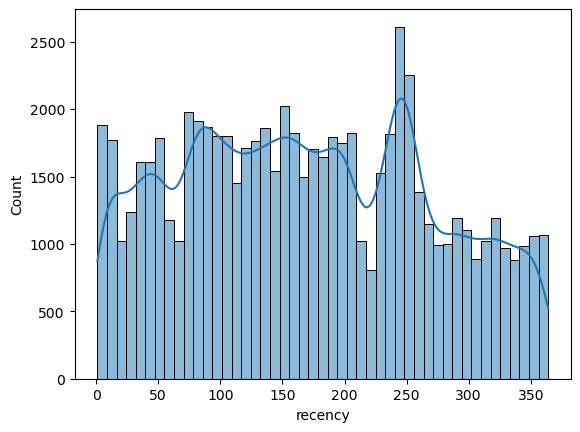

In [16]:
print(rfm_data['recency'].describe())
sns.histplot(x='recency', data=rfm_data, kde=True)

In [17]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(rfm_data['recency'], 4, labels = r_labels)
rfm_data = rfm_data.assign(R = r_quartiles.values)

In [18]:
rfm_data.head()

,customer_id,recency,frequency,monetary,R
0,0000366f3b9a7992bf8c76cfdf3221e2,82,1,129.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85,1,18.90,4
2,0000f6ccb0745a6a4b88665a16c9f078,292,1,25.99,1
3,0004aac84e0df4da2b147fca70cf8255,259,1,180.00,1
4,0004bd2a26a76fe21f786e4fbd80607f,117,1,154.00,3


### 3.3.2 Monetary(M)

count    69749.000000
mean       141.348120
std        210.777558
min          0.850000
25%         47.990000
50%         89.900000
75%        153.960000
max      13440.000000
Name: monetary, dtype: float64


<AxesSubplot:xlabel='monetary', ylabel='Count'>

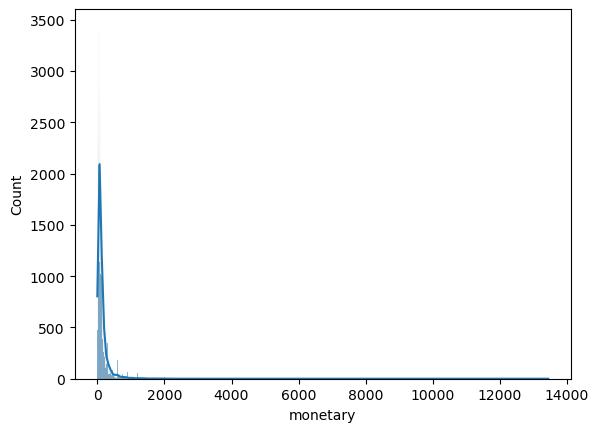

In [19]:
print(rfm_data['monetary'].describe())
sns.histplot(x='monetary', data=rfm_data, kde=True)

In [20]:
m_labels = range(4, 0, -1)
m_quartiles = pd.qcut(rfm_data['monetary'], 4, labels = m_labels)
rfm_data = rfm_data.assign(M = m_quartiles.values)

In [21]:
rfm_data.head()

,customer_id,recency,frequency,monetary,R,M
0,0000366f3b9a7992bf8c76cfdf3221e2,82,1,129.90,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85,1,18.90,4,4
2,0000f6ccb0745a6a4b88665a16c9f078,292,1,25.99,1,4
3,0004aac84e0df4da2b147fca70cf8255,259,1,180.00,1,1
4,0004bd2a26a76fe21f786e4fbd80607f,117,1,154.00,3,1


### 3.3.3 Frquency(F)

0.05687536738877977
count    69749.000000
mean         1.067987
std          0.312001
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         13.000000
Name: frequency, dtype: float64


<AxesSubplot:xlabel='frequency', ylabel='Count'>

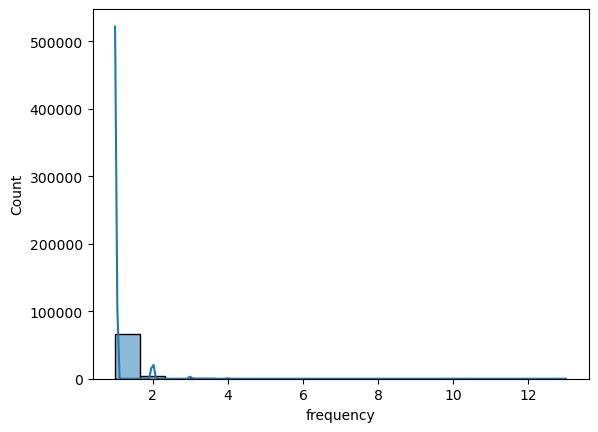

In [22]:
print(rfm_data[rfm_data['frequency']>1].shape[0] / rfm_data.shape[0])
print(rfm_data['frequency'].describe())
sns.histplot(x='frequency', data=rfm_data, kde=True)

The frequency distribution is skewed, indicating that over 75% of customers made just one purchase for the last one year. Given this distribution, manual binning is not appropriate, so we will explore other clustering techniques such as K-means to segment the frequency data.

In [23]:
rfm_data.describe()

,recency,frequency,monetary
count,69749.000000,69749.000000,69749.000000
mean,169.490946,1.067987,141.348120
std,98.539392,0.312001,210.777558
min,1.000000,1.000000,0.850000
25%,88.000000,1.000000,47.990000
50%,165.000000,1.000000,89.900000
75%,248.000000,1.000000,153.960000
max,364.000000,13.000000,13440.000000


### 3.3.4 Data Transformation to manage skewness

##### Monetary Log Transformation

C:\Users\JIYOON JUNG\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


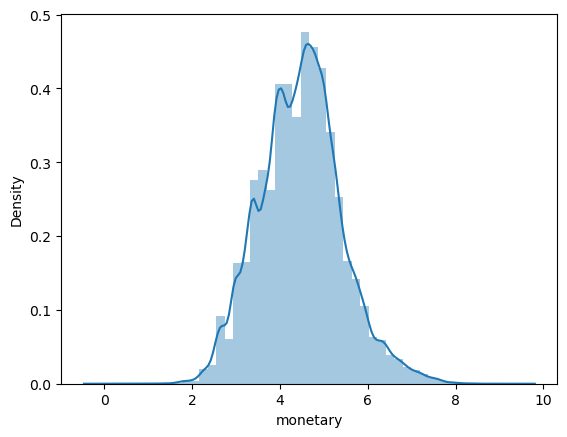

In [24]:
monetary_log= np.log(rfm_data['monetary'])
sns.distplot(monetary_log)
plt.show()

In [25]:
rfm_data['monetary_log'] = np.log(rfm_data['monetary'])
rfm_data.describe()

,recency,frequency,monetary,monetary_log
count,69749.000000,69749.000000,69749.000000,69749.000000
mean,169.490946,1.067987,141.348120,4.473073
std,98.539392,0.312001,210.777558,0.933624
min,1.000000,1.000000,0.850000,-0.162519
25%,88.000000,1.000000,47.990000,3.870993
50%,165.000000,1.000000,89.900000,4.498698
75%,248.000000,1.000000,153.960000,5.036693
max,364.000000,13.000000,13440.000000,9.505991


##### Frequency Log Transformation

C:\Users\JIYOON JUNG\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


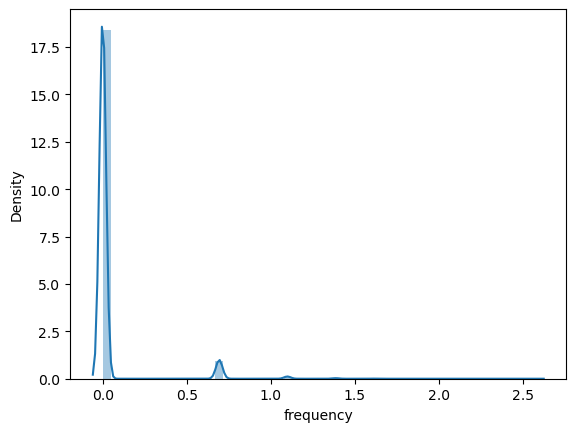

In [26]:
frequency_log= np.log(rfm_data['frequency'])
sns.distplot(frequency_log)
plt.show()

In [27]:
rfm_data['frequency_log'] = np.log(rfm_data['frequency'])
rfm_data.describe()

,recency,frequency,monetary,monetary_log,frequency_log
count,69749.000000,69749.000000,69749.000000,69749.000000,69749.000000
mean,169.490946,1.067987,141.348120,4.473073,0.043425
std,98.539392,0.312001,210.777558,0.933624,0.182642
min,1.000000,1.000000,0.850000,-0.162519,0.000000
25%,88.000000,1.000000,47.990000,3.870993,0.000000
50%,165.000000,1.000000,89.900000,4.498698,0.000000
75%,248.000000,1.000000,153.960000,5.036693,0.000000
max,364.000000,13.000000,13440.000000,9.505991,2.564949


### 3.3.5 Centering Variables with different means

In [28]:
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69749 entries, 0 to 69748
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customer_id    69749 non-null  object  
 1   recency        69749 non-null  int64   
 2   frequency      69749 non-null  int64   
 3   monetary       69749 non-null  float64 
 4   R              69749 non-null  category
 5   M              69749 non-null  category
 6   monetary_log   69749 non-null  float64 
 7   frequency_log  69749 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(1)
memory usage: 3.3+ MB


In [29]:
numeric_cols = ['recency', 'frequency', 'monetary', 'monetary_log']

scaler = StandardScaler()
rfm_data[numeric_cols] = scaler.fit_transform(rfm_data[numeric_cols])
print(rfm_data.head())

                        customer_id   recency  frequency  monetary  R  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2 -0.887884  -0.217907 -0.054314  4  2   
1  0000b849f77a49e4a4ce2b2a4ca5be3f -0.857439  -0.217907 -0.580939  4  4   
2  0000f6ccb0745a6a4b88665a16c9f078  1.243258  -0.217907 -0.547302  1  4   
3  0004aac84e0df4da2b147fca70cf8255  0.908365  -0.217907  0.183379  1  1   
4  0004bd2a26a76fe21f786e4fbd80607f -0.532694  -0.217907  0.060025  3  1   

   monetary_log  frequency_log  
0      0.421684            0.0  
1     -1.642977            0.0  
2     -1.301777            0.0  
3      0.771070            0.0  
4      0.603973            0.0  


In [30]:
rfm_data.describe()

,recency,frequency,monetary,monetary_log,frequency_log
count,6.974900e+04,6.974900e+04,6.974900e+04,6.974900e+04,69749.000000
mean,-2.959523e-17,1.698519e-15,-6.561393e-17,-3.789791e-16,0.043425
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.182642
min,-1.709896e+00,-2.179065e-01,-6.665754e-01,-4.965197e+00,0.000000
25%,-8.269945e-01,-2.179065e-01,-4.429257e-01,-6.448903e-01,0.000000
50%,-4.557546e-02,-2.179065e-01,-2.440890e-01,2.744676e-02,0.000000
75%,7.967333e-01,-2.179065e-01,5.983545e-02,6.036947e-01,0.000000
max,1.973936e+00,3.824374e+01,6.309375e+01,5.390773e+00,2.564949


In [31]:
rfm_data_norm = rfm_data[['customer_id', 'recency', 'frequency', 'monetary']]

In [32]:
rfm_data_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69749 entries, 0 to 69748
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69749 non-null  object 
 1   recency      69749 non-null  float64
 2   frequency    69749 non-null  float64
 3   monetary     69749 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.1+ MB


# 3.4 K-mean Clustering

#####  Label Encoding

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
rfm_data_norm['customer_id_encoded'] = label_encoder.fit_transform(rfm_data_norm['customer_id'])
print(rfm_data_norm.head())

                        customer_id   recency  frequency  monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2 -0.887884  -0.217907 -0.054314   
1  0000b849f77a49e4a4ce2b2a4ca5be3f -0.857439  -0.217907 -0.580939   
2  0000f6ccb0745a6a4b88665a16c9f078  1.243258  -0.217907 -0.547302   
3  0004aac84e0df4da2b147fca70cf8255  0.908365  -0.217907  0.183379   
4  0004bd2a26a76fe21f786e4fbd80607f -0.532694  -0.217907  0.060025   

   customer_id_encoded  
0                    0  
1                    1  
2                    2  
3                    3  
4                    4  


C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_29304\3533201746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data_norm['customer_id_encoded'] = label_encoder.fit_transform(rfm_data_norm['customer_id'])


In [34]:
import hashlib

def hash_customer_id(customer_id):
    return int(hashlib.sha256(customer_id.encode('utf-8')).hexdigest(), 16) % 10**8

rfm_data_norm['customer_id_hashed'] = rfm_data_norm['customer_id'].apply(hash_customer_id)

print(rfm_data_norm.head())

                        customer_id   recency  frequency  monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2 -0.887884  -0.217907 -0.054314   
1  0000b849f77a49e4a4ce2b2a4ca5be3f -0.857439  -0.217907 -0.580939   
2  0000f6ccb0745a6a4b88665a16c9f078  1.243258  -0.217907 -0.547302   
3  0004aac84e0df4da2b147fca70cf8255  0.908365  -0.217907  0.183379   
4  0004bd2a26a76fe21f786e4fbd80607f -0.532694  -0.217907  0.060025   

   customer_id_encoded  customer_id_hashed  
0                    0            74016217  
1                    1             9180155  
2                    2            27180657  
3                    3            94074144  
4                    4            30897332  


C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_29304\3787163092.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data_norm['customer_id_hashed'] = rfm_data_norm['customer_id'].apply(hash_customer_id)


In [35]:
rfm_data_norm['customer_id_hashed'] = rfm_data_norm['customer_id_hashed'].astype(float)

C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_29304\628377302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data_norm['customer_id_hashed'] = rfm_data_norm['customer_id_hashed'].astype(float)


In [36]:
rfm_data_norm = rfm_data_norm[['customer_id_hashed', 'recency', 'frequency', 'monetary']]

In [37]:
rfm_data_norm.head()

,customer_id_hashed,recency,frequency,monetary
0,74016217.0,-0.887884,-0.217907,-0.054314
1,9180155.0,-0.857439,-0.217907,-0.580939
2,27180657.0,1.243258,-0.217907,-0.547302
3,94074144.0,0.908365,-0.217907,0.183379
4,30897332.0,-0.532694,-0.217907,0.060025


In [38]:
rfm_data_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69749 entries, 0 to 69748
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_hashed  69749 non-null  float64
 1   recency             69749 non-null  float64
 2   frequency           69749 non-null  float64
 3   monetary            69749 non-null  float64
dtypes: float64(4)
memory usage: 2.1 MB


In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

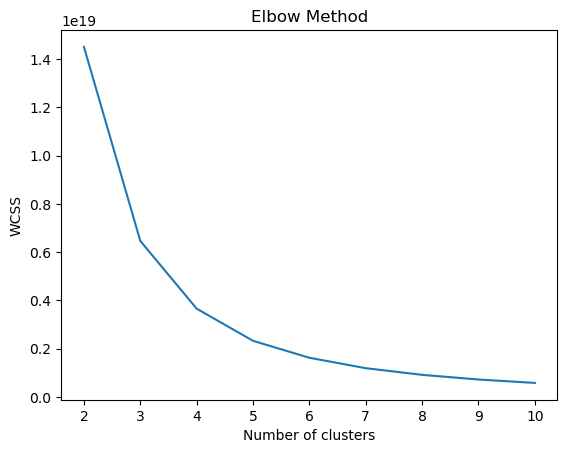

In [40]:
# Step 1: Determine the optimal number of clusters using the Elbow Method
wcss = []
silhouette_coefficients = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_data_norm)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(rfm_data_norm, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plotting the Elbow Method graph
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

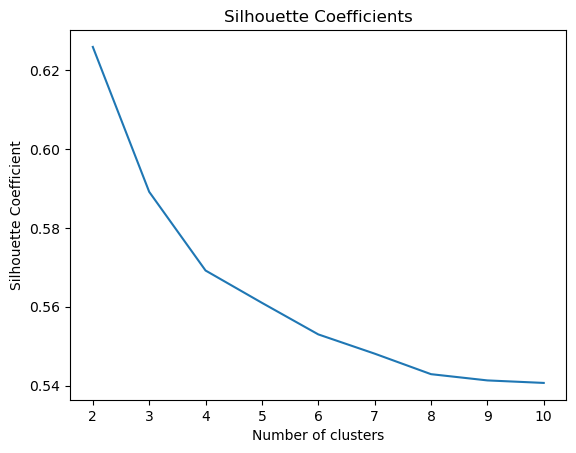

In [41]:
# Plotting the Silhouette Coefficients graph
plt.plot(range(2, 11), silhouette_coefficients)
plt.title('Silhouette Coefficients')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

In [45]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, random_state=42)

cluster_labels = kmeans.fit_predict(rfm_data_norm)

rfm_data_norm['cluster'] = cluster_labels

clusters = {}

for i in range(k):
    clusters[i] = rfm_data_norm[rfm_data_norm['cluster'] == i]

for i in range(k):
    print(f"Cluster {i}:")
    print(clusters[i].describe())

Cluster 0:
       customer_id_hashed       recency     frequency      monetary  cluster
count        1.745800e+04  17458.000000  17458.000000  17458.000000  17458.0
mean         6.283227e+07     -0.004103      0.002587     -0.001116      0.0
std          7.217971e+06      0.999398      1.003834      0.993230      0.0
min          5.032687e+07     -1.709896     -0.217907     -0.666575      0.0
25%          5.663101e+07     -0.834606     -0.217907     -0.444539      0.0
50%          6.280073e+07     -0.055724     -0.217907     -0.244089      0.0
75%          6.909737e+07      0.796733     -0.217907      0.050536      0.0
max          7.528133e+07      1.973936     19.012918     31.254272      0.0
Cluster 1:
       customer_id_hashed       recency     frequency      monetary  cluster
count        1.732400e+04  17324.000000  17324.000000  17324.000000  17324.0
mean         1.267244e+07      0.003547      0.001517      0.000906      1.0
std          7.300995e+06      1.003789      1.016622 

In [46]:
import pandas as pd

summary_stats = [] 

for i in range(k):
    cluster_description = clusters[i].describe()
    display(cluster_description)

,customer_id_hashed,recency,frequency,monetary,cluster
count,1.745800e+04,17458.000000,17458.000000,17458.000000,17458.0
mean,6.283227e+07,-0.004103,0.002587,-0.001116,0.0
std,7.217971e+06,0.999398,1.003834,0.993230,0.0
min,5.032687e+07,-1.709896,-0.217907,-0.666575,0.0
25%,5.663101e+07,-0.834606,-0.217907,-0.444539,0.0
50%,6.280073e+07,-0.055724,-0.217907,-0.244089,0.0
75%,6.909737e+07,0.796733,-0.217907,0.050536,0.0
max,7.528133e+07,1.973936,19.012918,31.254272,0.0


,customer_id_hashed,recency,frequency,monetary,cluster
count,1.732400e+04,17324.000000,17324.000000,17324.000000,17324.0
mean,1.267244e+07,0.003547,0.001517,0.000906,1.0
std,7.300995e+06,1.003789,1.016622,0.991442,0.0
min,5.680000e+02,-1.709896,-0.217907,-0.652342,1.0
25%,6.326695e+06,-0.837143,-0.217907,-0.438608,1.0
50%,1.276320e+07,-0.040501,-0.217907,-0.244089,1.0
75%,1.896351e+07,0.796733,-0.217907,0.060025,1.0
max,2.520691e+07,1.973936,25.423193,33.299096,1.0


,customer_id_hashed,recency,frequency,monetary,cluster
count,1.768300e+04,17683.000000,17683.000000,17683.000000,17683.0
mean,3.775726e+07,-0.001232,-0.005838,0.009135,2.0
std,7.279910e+06,0.998844,0.986358,0.970423,0.0
min,2.521226e+07,-1.709896,-0.217907,-0.666575,2.0
25%,3.149101e+07,-0.832069,-0.217907,-0.438608,2.0
50%,3.773740e+07,-0.055724,-0.217907,-0.244089,2.0
75%,4.403475e+07,0.796733,-0.217907,0.083747,2.0
max,5.032430e+07,1.973936,38.243743,17.827699,2.0


,customer_id_hashed,recency,frequency,monetary,cluster
count,1.728400e+04,17284.000000,17284.000000,17284.000000,17284.0
mean,8.763282e+07,0.001850,0.001839,-0.009127,3.0
std,7.163828e+06,0.998081,0.993251,1.044221,0.0
min,7.528296e+07,-1.709896,-0.217907,-0.656422,3.0
25%,8.147678e+07,-0.826994,-0.217907,-0.444539,3.0
50%,8.766130e+07,-0.045575,-0.217907,-0.248359,3.0
75%,9.382027e+07,0.796733,-0.217907,0.041048,3.0
max,9.999776e+07,1.973936,25.423193,63.093753,3.0


In [47]:
rfm_data_norm.head()

,customer_id_hashed,recency,frequency,monetary,cluster
0,74016217.0,-0.887884,-0.217907,-0.054314,0
1,9180155.0,-0.857439,-0.217907,-0.580939,1
2,27180657.0,1.243258,-0.217907,-0.547302,2
3,94074144.0,0.908365,-0.217907,0.183379,3
4,30897332.0,-0.532694,-0.217907,0.060025,2


In [48]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,...,customer_state,geolocation_lat,geolocation_lng,product_category_name_english,order_size,product_order_size,Year,Month,product_sales_amt,order_sales_amt
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,...,SP,-23.576170,-46.587276,housewares,1,1,2017,10,29.99,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,...,BA,-12.126651,-45.008162,perfumery,1,1,2018,7,118.70,118.70
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,...,RN,-5.774611,-35.273916,pet_shop,1,1,2017,11,45.00,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,...,SP,-23.675316,-46.515116,stationery,1,1,2018,2,19.90,19.90
11,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-07-18,72a97c271b2e429974398f46b93ae530,094ced053e257ae8cae57205592d6712,2018-06-18 03:13:12,31.90,18.23,...,MG,-20.386870,-43.506711,perfumery,1,1,2018,6,31.90,31.90
